## MAD GAN

In [15]:
# Initialization of libraries
import torch
import torch.nn
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import random
from random import randint
from sklearn.mixture import GMM
device = torch.device('cuda')
%matplotlib inline

In [16]:
# defining parameters for the training
mb_size = 128 # Batch Size
Z_dim = 64  # Length of noise vector
X_dim = 1  # Input Length
h_dim = 128  # Hidden Dimension
lr = 1e-4    # Learning Rate
num_gen = 4

/home/shyam.nandan/.local/lib/python2.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)


(array([ 1.,  0.,  0., ...,  0.,  0.,  1.]),
 array([  0.00000000e+00,   5.00000000e-06,   1.00000000e-05, ...,
          9.99990000e-01,   9.99995000e-01,   1.00000000e+00]),
 <a list of 1 Patch objects>)

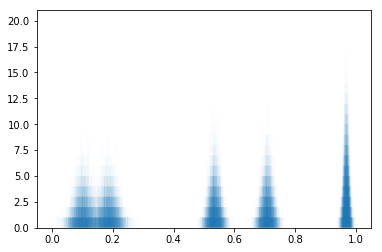

In [3]:
np.random.seed(1)
gmm = GMM(5)
gmm.means_ = np.array([[10], [20], [60], [80], [110]])
gmm.covars_ = np.array([[3], [3], [2], [2], [1]]) ** 2
gmm.weights_ = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

X = gmm.sample(200000)
data = X
data = (data - X.min())/(X.max()-X.min())
plt.hist(data, 200000, normed=False, histtype='stepfilled', alpha=1)

In [4]:
G = []
for i in range(num_gen):
    G.append(torch.nn.Sequential(
        torch.nn.Linear(Z_dim, h_dim),
        torch.nn.PReLU(),
        torch.nn.Linear(h_dim, h_dim),
        torch.nn.PReLU(),
        torch.nn.Linear(h_dim, X_dim),
        torch.nn.Sigmoid()
    ).cuda())

D = torch.nn.Sequential(
    torch.nn.Linear(X_dim, h_dim),
    torch.nn.LeakyReLU(0.2),
    torch.nn.Linear(h_dim, h_dim),
    torch.nn.LeakyReLU(0.2),
    torch.nn.Linear(h_dim, num_gen + 1),
    torch.nn.Softmax()
).cuda()

In [5]:
G_solver = []
for i in range(num_gen):
    G_solver.append(optim.Adam(G[i].parameters(), lr))
D_solver = optim.Adam(D.parameters(), lr)
###
loss = nn.CrossEntropyLoss()
label_G = Variable(torch.LongTensor(mb_size))
label_G = label_G.to(device)
label_D = Variable(torch.LongTensor(mb_size))
label_D = label_D.to(device)

In [6]:
# Reset the gradients to zero
params = [G[0], G[1], G[2], G[3], D]
def reset_grad():
    for net in params:
        net.zero_grad()
reset_grad()

In [7]:
data_index = 0
for it in range(198000):
    if ((data_index + 1)*mb_size>len(data)):
        data_index = 0

    X = torch.from_numpy(np.array(data[data_index*mb_size : (data_index + 1)*mb_size]))
    X = X.view(mb_size, 1)
    X = X.type(torch.FloatTensor)
    X = X.to(device)
    Total_D_loss = 0
    for i in range(num_gen):
        # Dicriminator forward-loss-backward-update
        #forward pass
        z = torch.FloatTensor(mb_size, Z_dim).uniform_(-1, 1)
        z = z.to(device)
        G_sample = G[i](z)
        D_real = D(X)
        D_fake = D(G_sample)
        # Calculate the loss
        D_loss_real = loss(D_real,label_D.fill_(num_gen + 0.1*randint(-1,1)))
        D_loss_fake = loss(D_fake, label_G.fill_(i + 0.1*randint(-1,1)))
        D_loss = D_loss_real + D_loss_fake
        Total_D_loss = D_loss + Total_D_loss
        # Calulate and update gradients of discriminator
        D_loss.backward()
        D_solver.step()

        # reset gradient
        reset_grad()

    # Generator forward-loss-backward-update
    
    Total_G_loss = 0
    for i in range(num_gen):
        
        z = torch.FloatTensor(mb_size, Z_dim).uniform_(-1, 1)
        z = z.to(device)
        G_sample = G[i](z)
        D_fake = D(G_sample)

        G_loss = loss(D_fake, label_D.fill_(num_gen + 0.1*randint(-1,1)))
        Total_G_loss = G_loss + Total_G_loss
        G_loss.backward()
        G_solver[i].step()

        # reset gradient
        reset_grad()
        
    data_index = data_index + 1
    # Print and plot every now and then
    if it % 1000 == 0:
        print('Iter-{}; D_loss: {}; G_loss: {}'.format(it, Total_D_loss.data.cpu().numpy(), Total_G_loss.data.cpu().numpy()))

/home/shyam.nandan/.local/lib/python2.7/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Iter-0; D_loss: 12.8343067169; G_loss: 6.44309520721
Iter-1000; D_loss: 11.8162298203; G_loss: 5.75694847107
Iter-2000; D_loss: 12.2322769165; G_loss: 5.86067295074
Iter-3000; D_loss: 12.512131691; G_loss: 5.07155609131
Iter-4000; D_loss: 12.2952156067; G_loss: 5.54977607727
Iter-5000; D_loss: 12.4679040909; G_loss: 5.28224134445
Iter-6000; D_loss: 11.6162033081; G_loss: 5.33512115479
Iter-7000; D_loss: 11.9482212067; G_loss: 6.25536155701
Iter-8000; D_loss: 12.9537563324; G_loss: 6.14956378937
Iter-9000; D_loss: 12.4838132858; G_loss: 6.00045537949
Iter-10000; D_loss: 11.9373083115; G_loss: 5.06630373001
Iter-11000; D_loss: 12.490530014; G_loss: 6.20711040497
Iter-12000; D_loss: 12.5085783005; G_loss: 6.16673660278
Iter-13000; D_loss: 11.6566467285; G_loss: 5.36638450623
Iter-14000; D_loss: 12.9825077057; G_loss: 6.06074047089
Iter-15000; D_loss: 11.6715431213; G_loss: 5.62514352798
Iter-16000; D_loss: 12.2253437042; G_loss: 5.83064842224
Iter-17000; D_loss: 12.4833259583; G_loss: 5.8

Iter-144000; D_loss: 12.5456905365; G_loss: 5.02406978607
Iter-145000; D_loss: 11.4033050537; G_loss: 5.54800891876
Iter-146000; D_loss: 12.2819213867; G_loss: 6.05532884598
Iter-147000; D_loss: 13.3139381409; G_loss: 5.03415679932
Iter-148000; D_loss: 11.9964923859; G_loss: 4.76354455948
Iter-149000; D_loss: 12.0977611542; G_loss: 5.4749083519
Iter-150000; D_loss: 12.763338089; G_loss: 4.92749452591
Iter-151000; D_loss: 12.6116533279; G_loss: 5.767993927
Iter-152000; D_loss: 11.5472555161; G_loss: 6.19716978073
Iter-153000; D_loss: 11.7522315979; G_loss: 5.7862830162
Iter-154000; D_loss: 11.8820419312; G_loss: 4.84447860718
Iter-155000; D_loss: 12.7368402481; G_loss: 5.38472747803
Iter-156000; D_loss: 12.3887901306; G_loss: 5.13296985626
Iter-157000; D_loss: 11.9174575806; G_loss: 5.70501470566
Iter-158000; D_loss: 12.8244915009; G_loss: 5.76585054398
Iter-159000; D_loss: 11.4775714874; G_loss: 5.15147686005
Iter-160000; D_loss: 12.0820674896; G_loss: 4.94896507263
Iter-161000; D_loss

 Let us see the images generated by the generator:

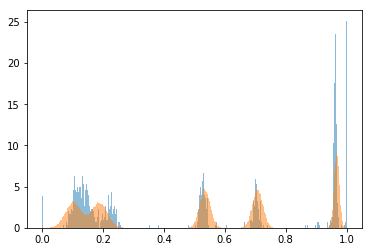

In [18]:
import numpy as np
final = np.zeros(1500*mb_size, dtype = float)
for i in range(1500):
    z = torch.FloatTensor(64, Z_dim).uniform_(-1, 1)
    z = z.to(device)
    l = G[randint(0,num_gen-1)](z).cpu().detach().numpy()
    final[i*mb_size : ((i+ 1)*mb_size -1)] = l[0]
p1 = plt.hist(final, 500, normed=True, histtype='bar', alpha=0.5)
p2 = plt.hist(data, 500, normed=True, histtype='bar', alpha=0.5)